<a href="https://colab.research.google.com/github/Pablo2710/ProyectoDSI/blob/main/ProyectoDSParteIII_Martinez_Pablo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pablo A. Martinez

Data Science I - CoderHouse





# **Detección Exploratoria de Fraude en Transacciones Financieras**

Este proyecto se inicia con un Análisis Exploratorio de Datos (EDA) sobre un conjunto sintético de $\mathbf{5 \text{ millones}}$ de transacciones financieras. Este dataset fue generado mediante un script de Python, para replicar comportamientos de fraude y anomalías del mundo real, proporcionando una base sólida para investigaciones de Data Science. El conjunto de datos abarca $\mathbf{18 \text{ atributos}}$ detallados, incluyendo variables críticas como los montos (amount), el tipo de transacción, características de comportamiento de la cuenta (como el velocity_score y el spending_deviation_score), metadatos contextuales (location, device_used) y la etiqueta binaria de fraude (is_fraud).
La etapa inicial tiene un doble propósito: primero, obtener una comprensión profunda de la distribución y composición de las transacciones fraudulentas; y segundo, identificar las señales de alerta más fuertes que guiarán la construcción de un modelo predictivo robusto. Para lograr esto, utilizaremos visualizaciones y resúmenes numéricos para validar hipótesis clave.
La exploración se centrará en responder si las transacciones marcadas como fraude presentan un patrón estadísticamente diferente al de las transacciones legítimas. Esto implica investigar la relación entre el amount, los indicadores de riesgo de comportamiento y la etiqueta is_fraud mediante análisis bivariados. Además, se desarrollarán gráficos multivariados que permitan diagnosticar la interacción de tres o más factores contextuales (como la combinación de $\text{"transaction_type"}$, $\text{"merchant_category"}$ y $\text{"location"}$) y su impacto en la tasa de fraude.
El proceso también incluirá un paso esencial de diagnóstico de la calidad de los datos, con una identificación explícita de los valores perdidos, particularmente en variables como $\text{"time_since_last_transaction"}$ y $\text{"fraud_type"}$. Los resultados de este EDA no solo proporcionarán una visión clara de los drivers del fraude, sino que también servirán de base empírica para la ingeniería de características y el enfoque de modelado en etapas posteriores del proyecto.

## *PREGUNTAS E HIPOTESIS*

***Problemas a Resolver***

1.  ¿Cuál es la tasa de fraude global y cómo se distribuyen las transacciones fraudulentas según la hora o el día?
2.   Hay diferencias significativas en el amount promedio o en el velocity_score entre las transacciones fraudulentas y las legítimas? (Análisis Bivariado)
1.   ¿Cuales combinaciones de factores (por ejemplo, transaction_type, location y device_used) muestran una mayor proporción de fraude?
2.  ¿Cómo influyen los indicadores de riesgo calculados (como spending_deviation_score y geo_anomaly_score) en la probabilidad de que una transacción sea catalogada como fraude? (Análisis Multivariado/Correlación)

***Hipótesis a Comprobar***


*   **H1 (Monto y Velocidad):** Las transacciones fraudulentas tendrán un "amount" mucho mayor que la mediana y un velocity_score significativamente más alto (más transacciones en poco tiempo), indicando actividad sospechosa.
*   **H2 (Categoría/Ubicación):** Habrá mayor probabilidad de fraude asociada con ciertas "merchant_category" cuando la "location" no es la habitual del usuario (indicada por un alto "geo_anomaly_score").
*   **H3 (Dispositivo y Tipo):** El fraude es más frecuente en transacciones de tipo "transfer" o "withdrawal" y cuando el "device_used" es "mobile" o "atm", en comparación con el uso de pos.


## *Importación de Librerías y Configuración de Visualizaciones*

In [1]:
# Importar Librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc, roc_auc_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Configuraciones de visualización
sns.set_theme(style="whitegrid") # Establece un tema estético para los gráficos
plt.rcParams['figure.figsize'] = (12, 6) # Establece un tamaño de figura por defecto
warnings.filterwarnings('ignore') # Ignora advertencias

##*Análisis Exploratorio de Datos*

In [2]:
 # 1. Cargar el dataset directamente desde GitHub
financial_fraud=pd.read_csv('https://media.githubusercontent.com/media/Pablo2710/ProyectoDSI/refs/heads/main/financial_fraud_detection_dataset.csv')

In [3]:
# 2. Confirmación de la carga exitosa
print("\nPrimeras 5 filas:")
display(financial_fraud.head())
print("\n\nÚltimas 5 filas:")
display(financial_fraud.tail())
print("\n\nInformación del DataFrame:")
print(f"\nDimensiones: {financial_fraud.shape}")
print(f"\nColumnas: {financial_fraud.columns}\n")


Primeras 5 filas:


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
0,T100000,2023-08-22T09:22:43.516168,ACC877572,ACC388389,343.78,withdrawal,utilities,Tokyo,mobile,False,NaN,NaN,-0.21,3,0.22,card,13.101.214.112,D8536477
1,T100001,2023-08-04T01:58:02.606711,ACC895667,ACC944962,419.65,withdrawal,online,Toronto,atm,False,NaN,NaN,-0.14,7,0.96,ACH,172.52.47.194,D2622631
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,False,NaN,NaN,-1.78,20,0.89,card,185.98.35.23,D4823498
3,T100003,2023-10-10T06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,False,NaN,NaN,-0.60,6,0.37,wire_transfer,107.136.36.87,D9961380
4,T100004,2023-09-24T08:09:02.700162,ACC584714,ACC497887,24.43,transfer,utilities,Toronto,mobile,False,NaN,NaN,0.79,13,0.27,ACH,108.161.108.255,D7637601




Últimas 5 filas:


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
4999995,T5099995,2023-11-17T23:20:29.746144,ACC597319,ACC749300,10.87,withdrawal,retail,Toronto,atm,False,NaN,1416.524233,-0.14,17,0.18,UPI,243.92.38.163,D4439579
4999996,T5099996,2023-09-23T11:23:20.659686,ACC749625,ACC709783,181.40,payment,grocery,Sydney,atm,False,NaN,999.089702,-1.79,4,0.58,wire_transfer,28.252.18.249,D5029311
4999997,T5099997,2023-11-18T00:52:34.527092,ACC629492,ACC680736,12.54,payment,utilities,New York,mobile,False,NaN,3871.584025,-0.30,6,0.99,card,111.199.174.121,D6333607
4999998,T5099998,2023-03-25T04:32:13.609837,ACC984720,ACC296935,376.29,deposit,restaurant,Dubai,pos,False,NaN,-4096.765453,-1.43,5,0.32,wire_transfer,221.110.215.14,D1551203
4999999,T5099999,2023-09-02T04:34:34.583803,ACC120255,ACC440137,7.27,transfer,grocery,Sydney,atm,False,NaN,5257.349021,0.08,14,0.40,wire_transfer,246.68.126.184,D1505627




Información del DataFrame:

Dimensiones: (5000000, 18)

Columnas: Index(['transaction_id', 'timestamp', 'sender_account', 'receiver_account',
       'amount', 'transaction_type', 'merchant_category', 'location',
       'device_used', 'is_fraud', 'fraud_type', 'time_since_last_transaction',
       'spending_deviation_score', 'velocity_score', 'geo_anomaly_score',
       'payment_channel', 'ip_address', 'device_hash'],
      dtype='object')



In [4]:
financial_fraud.dtypes

,0
transaction_id,object
timestamp,object
sender_account,object
receiver_account,object
amount,float64
transaction_type,object
merchant_category,object
location,object
device_used,object
is_fraud,bool


In [5]:
financial_fraud.count()

,0
transaction_id,5000000
timestamp,5000000
sender_account,5000000
receiver_account,5000000
amount,5000000
transaction_type,5000000
merchant_category,5000000
location,5000000
device_used,5000000
is_fraud,5000000


### *Descripción estadística del DataFrame:*

In [6]:
financial_fraud.describe().round(2).T

,count,mean,std,min,25%,50%,75%,max
amount,5000000.0,358.93,469.93,0.01,26.57,138.67,503.89,3520.57
time_since_last_transaction,4103487.0,1.53,3576.57,-8777.81,-2562.38,0.84,2568.34,8757.76
spending_deviation_score,5000000.0,-0.00,1.00,-5.26,-0.68,0.00,0.67,5.02
velocity_score,5000000.0,10.50,5.77,1.00,5.00,11.00,16.00,20.00
geo_anomaly_score,5000000.0,0.50,0.29,0.00,0.25,0.50,0.75,1.00


##*Limpieza de Datos*

### *Identificación de Valores Nulos*

In [7]:
# Cuenta valores nulos por columna
null_values_count = financial_fraud.isnull().sum()

# Calcula el porcentaje de valores nulos
total_rows = len(financial_fraud)
null_values_percentage = ((null_values_count / total_rows) * 100).round(2)

# Crea un DataFrame de resumen de valores nulos
missing_data = pd.DataFrame({
    'Valores Faltantes': null_values_count,
    'Porcentaje (%)': null_values_percentage
})

# Filtra y ordena las columnas con valores nulos
missing_data = missing_data[missing_data['Valores Faltantes'] > 0].sort_values(by='Porcentaje (%)', ascending=False)

print("Resumen de Columnas con Valores Nulos:")
display(missing_data)

Resumen de Columnas con Valores Nulos:


,Valores Faltantes,Porcentaje (%)
fraud_type,4820447,96.41
time_since_last_transaction,896513,17.93


**ANALISIS DE LOS VALORES NULOS**

*   *Columna fraud_type:*

    En este caso la ausencia de valor es informativa. El tipo de fraude solo se registra cuando la transacción es fraudulenta (is_fraud = True). El 96.41% de las transacciones son consideradas legítimas.

*   *Columna time_since_last_transaction:*

    La ausencia de valores probablemente corresponden a las primeras transacciones de las cuentas registradas, donde no existe un historial previo para calcular el tiempo transcurrido.

### *Tratamiento de Valores Nulos*

In [8]:
# Imputación Categórica: Reemplazamos NaN con 'No Fraude'
financial_fraud['fraud_type'].fillna('No Fraude', inplace=True)
# Verificación
print(f"Conteo después de imputar fraud_type:\n{financial_fraud['fraud_type'].value_counts().head()}")

Conteo después de imputar fraud_type:
fraud_type
No Fraude           4820447
card_not_present     179553
Name: count, dtype: int64


In [9]:
# Imputación Numérica: Reemplazamos NaN con -1
financial_fraud['time_since_last_transaction'].fillna(-1, inplace=True)

# Verificación
print(f"\nConteo de valores -1 en time_since_last_transaction: {financial_fraud['time_since_last_transaction'].value_counts().get(-1, 0)}")


Conteo de valores -1 en time_since_last_transaction: 896513


Optaremos por el valor $-1$ porque preserva y codifica la ausencia de historial como una señal predictiva, que es más valiosa en la detección de fraude.

### *Identificación de Valores Duplicados*

In [10]:
financial_fraud.duplicated().sum()

np.int64(0)

### *Detección de Outliers*

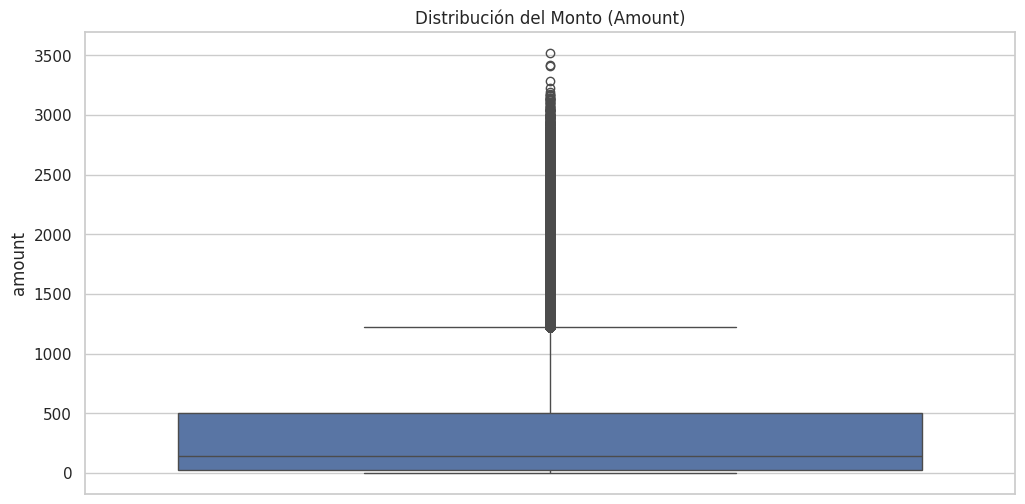

In [11]:
# Boxplot de la variable 'amount'
sns.boxplot(financial_fraud['amount'])
plt.title('Distribución del Monto (Amount)')
plt.show()

El BoxPlot de la variable amount muestra una extrema concentración de los datos y una alta dispersión de valores atípicos (outliers):

1.   Concentración Central: La caja que representa el Rango Intercuartílico es extremadamente pequeña y está muy cerca del cero, lo que indica que la gran mayoría de las transacciones son de montos bajos o moderados.La mediana es muy baja, lo que confirma que el 50% de las transacciones tienen un valor inferior a ese punto.
2.   Presencia de Outliers: El gráfico está dominado por una gran cantidad de puntos por encima del "bigote" superior. Existen transacciones con montos que superan los $3500$ (e incluso más allá), mientras que el 75% de las transacciones está considerablemente por debajo de los $1250$ (el valor del bigote superior es aproximadamente $1250$).Esta fuerte presencia de outliers indica que la variable amount presenta una distribución altamente asimétrica (o sesgada a la derecha).

Rango Intercuartílico (IQR)

In [12]:
# 1. Calculamos Q1 y Q3
Q1_amount = financial_fraud['amount'].quantile(0.25)
Q3_amount = financial_fraud['amount'].quantile(0.75)

# 2. Calculamos el IQR
IQR_amount = Q3_amount - Q1_amount

# 3. Definimos los límites
limite_inferior_amount = Q1_amount - 1.5 * IQR_amount
limite_superior_amount = Q3_amount + 1.5 * IQR_amount

In [13]:
print(f"Análisis para la columna amount (Monto):\n")
print(f"Q1: {Q1_amount}")
print(f"Q3: {Q3_amount}")
print(f"IQR: {IQR_amount}")
print(f"Límite Inferior: {limite_inferior_amount}")
print(f"Límite Superior: {limite_superior_amount}")

Análisis para la columna amount (Monto):

Q1: 26.57
Q3: 503.89
IQR: 477.32
Límite Inferior: -689.41
Límite Superior: 1219.87


In [14]:
# Filtramos para encontrar los outliers
outliers_amount = financial_fraud[(financial_fraud['amount'] < limite_inferior_amount) | (financial_fraud['amount'] > limite_superior_amount)]

print("Outliers de Montos encontrados con el método IQR:")
display(outliers_amount)

Outliers de Montos encontrados con el método IQR:


,transaction_id,timestamp,sender_account,receiver_account,amount,transaction_type,merchant_category,location,device_used,is_fraud,fraud_type,time_since_last_transaction,spending_deviation_score,velocity_score,geo_anomaly_score,payment_channel,ip_address,device_hash
2,T100002,2023-05-12T11:39:33.742963,ACC733052,ACC377370,2773.86,deposit,other,London,pos,False,No Fraude,-1.000000,-1.78,20,0.89,card,185.98.35.23,D4823498
3,T100003,2023-10-10T06:04:43.195112,ACC996865,ACC344098,1666.22,deposit,online,Sydney,pos,False,No Fraude,-1.000000,-0.60,6,0.37,wire_transfer,107.136.36.87,D9961380
10,T100010,2023-08-04T00:35:03.745267,ACC717024,ACC330914,1237.07,deposit,travel,New York,web,False,No Fraude,-1.000000,1.64,3,0.51,card,142.248.109.67,D8930103
14,T100014,2023-03-11T13:30:19.142152,ACC161324,ACC707314,1283.35,deposit,restaurant,New York,mobile,False,No Fraude,-1.000000,-1.96,6,0.06,UPI,41.95.35.34,D4946066
15,T100015,2023-05-29T03:04:25.786373,ACC358175,ACC707040,1258.92,deposit,travel,Dubai,atm,False,No Fraude,-1.000000,-0.04,7,0.67,wire_transfer,160.122.135.202,D3195773
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4999949,T5099949,2023-06-30T07:25:20.100074,ACC430670,ACC652295,1653.69,deposit,utilities,Dubai,pos,False,No Fraude,772.832110,1.07,18,0.39,UPI,76.53.119.76,D2540705
4999954,T5099954,2023-03-20T01:24:14.552053,ACC253124,ACC414486,1462.66,deposit,utilities,Singapore,mobile,False,No Fraude,-4176.901457,-2.06,15,0.69,card,157.141.136.1,D4193563
4999955,T5099955,2023-07-28T19:10:38.265289,ACC382001,ACC331415,1263.16,deposit,restaurant,Dubai,pos,False,No Fraude,3504.952749,0.75,2,0.94,UPI,236.254.81.204,D3927351
4999966,T5099966,2023-04-20T16:06:45.861113,ACC995598,ACC830774,1785.69,deposit,other,Sydney,pos,False,No Fraude,-5558.039159,0.86,5,0.65,wire_transfer,186.116.74.237,D5932712


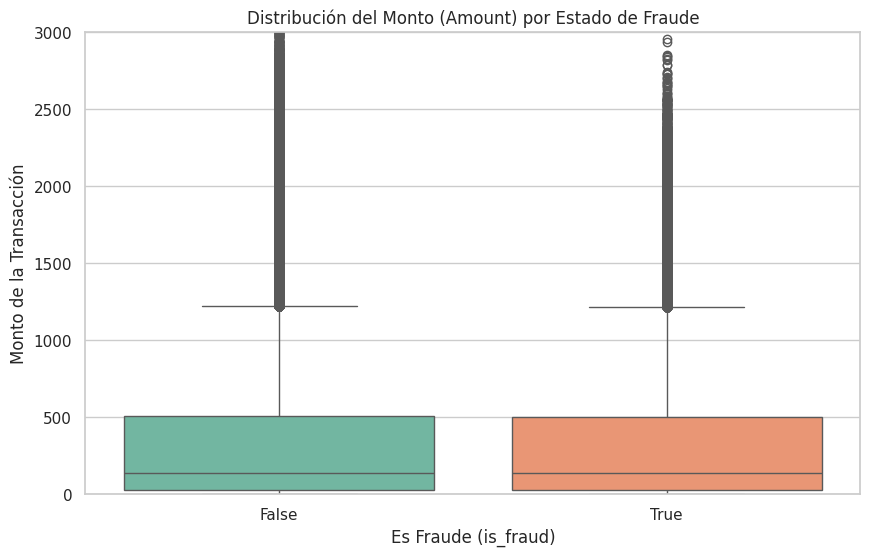

In [15]:
# Convertir 'is_fraud' a booleano
financial_fraud['is_fraud'] = financial_fraud['is_fraud'].astype(bool)

plt.figure(figsize=(10, 6))
# Usamos y='amount' y x='is_fraud' (la variable objetivo)
sns.boxplot(x='is_fraud', y='amount', data=financial_fraud, palette='Set2')
plt.title('Distribución del Monto (Amount) por Estado de Fraude')
plt.xlabel('Es Fraude (is_fraud)')
plt.ylabel('Monto de la Transacción')

# Limitamos el eje Y a un valor razonable para ver la caja del grupo "False"
# Esto ayuda a visualizar la asimetría sin que los outliers extremos dominen el gráfico
plt.ylim(0, 3000)

plt.show()

Este Box Plot confirma visualmente la conclusión numérica del análisis IQR: la gran mayoría de las transacciones (tanto legítimas como fraudulentas) se concentran en montos bajos. La presencia de una densa nube de outliers por encima de los $1219.87 en ambas clases demuestra que el monto atípico por sí solo no es un predictor fuerte. La Hipótesis H1 (que el monto es significativamente mayor en fraude) se refuta, reforzando la necesidad de centrar el modelo en las variables de comportamiento anómalo (spending_deviation_score, velocity_score) en lugar de las variables contextuales o de monto."

##Feature Engineering (Ingeniería de Características)

In [16]:
# 1. Separar X (features) e y (target)
# ¡CORRECCIÓN CRÍTICA: Eliminamos 'fraud_type' para evitar Sobreajuste
X = financial_fraud.drop(['is_fraud', 'fraud_type'], axis=1)
y = financial_fraud['is_fraud']

# 2. Identificar el tipo de columnas
numerical_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X.select_dtypes(include=['object']).columns.tolist()

# 3. Eliminar ID (si existe) y cualquier columna innecesaria de las numéricas
# Asumo que 'transaction_id' es innecesario para el modelo si existe
if 'transaction_id' in numerical_features:
    numerical_features.remove('transaction_id')
if 'customer_id' in numerical_features:
    numerical_features.remove('customer_id')

print("--- Estructura de Datos para el Preprocesamiento ---")
print(f"Características Numéricas a Escalar ({len(numerical_features)}): {numerical_features}")
print(f"Características Categóricas a Codificar ({len(categorical_features)}): {categorical_features}")

--- Estructura de Datos para el Preprocesamiento ---
Características Numéricas a Escalar (5): ['amount', 'time_since_last_transaction', 'spending_deviation_score', 'velocity_score', 'geo_anomaly_score']
Características Categóricas a Codificar (11): ['transaction_id', 'timestamp', 'sender_account', 'receiver_account', 'transaction_type', 'merchant_category', 'location', 'device_used', 'payment_channel', 'ip_address', 'device_hash']


## Preprocesamiento de Datos

In [17]:
# 1. Definir Transformadores
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore') # Ignorar categorías no vistas en entrenamiento

# 2. Definir el ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ],
    # Aseguramos que solo se usen las columnas especificadas
    remainder='drop'
)

# 3. Ver el Preprocesador (No genera salida gráfica, pero confirma la estructura)
print("\n--- ColumnTransformer Definido ---")
print(preprocessor)


--- ColumnTransformer Definido ---
ColumnTransformer(transformers=[('num', StandardScaler(),
                                 ['amount', 'time_since_last_transaction',
                                  'spending_deviation_score', 'velocity_score',
                                  'geo_anomaly_score']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['transaction_id', 'timestamp',
                                  'sender_account', 'receiver_account',
                                  'transaction_type', 'merchant_category',
                                  'location', 'device_used', 'payment_channel',
                                  'ip_address', 'device_hash'])])


##División de Datos (Train/Test Split)

In [18]:
# Dividir los datos, manteniendo la proporción de la variable objetivo (is_fraud)
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y  # Mantiene la proporción de clases
)

print("\n--- División de Datos ---")
print(f"Tamaño de Entrenamiento (X_train): {X_train.shape}")
print(f"Tamaño de Prueba (X_test): {X_test.shape}")
print(f"Proporción de Fraude en Train: {y_train.sum() / len(y_train) * 100:.4f}%")
print(f"Proporción de Fraude en Test: {y_test.sum() / len(y_test) * 100:.4f}%")


--- División de Datos ---
Tamaño de Entrenamiento (X_train): (4000000, 16)
Tamaño de Prueba (X_test): (1000000, 16)
Proporción de Fraude en Train: 3.5910%
Proporción de Fraude en Test: 3.5911%


##Construcción y Entrenamiento del Modelo (Random Forest)

### Estrategia de Muestreo Rápido
Debido al tamaño del dataset, en el entorno de ejecución que porporciona la versión gratuita de Colab, es inviable entrenar el modelo ya que el tiempo estimado es de 83 horas. Por tal motivo se decidió Reducir el Tamaño del Dataset de Entrenamiento utilizando una fracción de los datos de entrenamiento para obtener resultados rápidamente. Este subconjunto es del 5% del dataset original 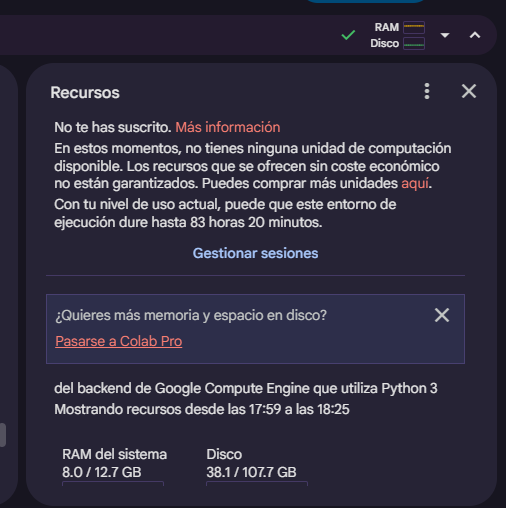

In [19]:
# =========================================================================
# ===   INICIO DE LA CELDA: SUBMUESTREO DEL CONJUNTO DE ENTRENAMIENTO   ===
# =========================================================================

# Usaremos un 10% (0.1) de X_train para el entrenamiento.
# Esto reduce 4 millones de filas a aproximadamente 400,000, lo cual es manejable.
fraccion = 0.05

# Seleccionar un 10% de las filas de entrenamiento (manteniendo la aleatoriedad)
X_train_subset = X_train.sample(frac=fraccion, random_state=42)

# Obtener las etiquetas correspondientes al subconjunto
y_train_subset = y_train.loc[X_train_subset.index]

print("--- Subconjunto de Entrenamiento Creado ---")
print(f"Tamaño original de X_train: {X_train.shape}")
print(f"Tamaño del Subconjunto para Entrenamiento: {X_train_subset.shape}")
print(f"Proporción de Fraude en el Subconjunto: {y_train_subset.sum() / len(y_train_subset) * 100:.4f}%")

# =========================================================================
# ===                       FIN DE LA NUEVA CELDA                       ===
# =========================================================================

--- Subconjunto de Entrenamiento Creado ---
Tamaño original de X_train: (4000000, 16)
Tamaño del Subconjunto para Entrenamiento: (200000, 16)
Proporción de Fraude en el Subconjunto: 3.5855%


In [20]:
# Crear el Pipeline final (Preprocesador + Clasificador)
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(
        n_estimators=100,
        random_state=42,
        n_jobs=-1, # Usa todos los núcleos disponibles para acelerar
        class_weight='balanced' # Importante para datos desbalanceados
    ))
])

print("\n--- Pipeline Final Definido y Entrenando Modelo... Esto puede tardar varios minutos ---")

# Entrenar el Pipeline completo USANDO EL SUBSET
model_pipeline.fit(X_train_subset, y_train_subset)

print("\nModelo Random Forest entrenado exitosamente.")


--- Pipeline Final Definido y Entrenando Modelo... Esto puede tardar varios minutos ---

Modelo Random Forest entrenado exitosamente.


##Evaluación del Modelo

In [21]:
# Realizar Predicciones
y_pred = model_pipeline.predict(X_test)
# Necesitamos probabilidades para la Curva ROC/AUC
y_pred_proba = model_pipeline.predict_proba(X_test)[:, 1]

print("\n--- Evaluación del Rendimiento en el Conjunto de Prueba ---")

# Reporte de Clasificación (Precision, Recall, F1-Score)
target_names = ['Legítima (False)', 'Fraude (True)']
print("\nReporte de Clasificación:")
print(classification_report(y_test, y_pred, target_names=target_names))



--- Evaluación del Rendimiento en el Conjunto de Prueba ---

Reporte de Clasificación:
                  precision    recall  f1-score   support

Legítima (False)       0.96      1.00      0.98    964089
   Fraude (True)       0.00      0.00      0.00     35911

        accuracy                           0.96   1000000
       macro avg       0.48      0.50      0.49   1000000
    weighted avg       0.93      0.96      0.95   1000000



###Confusion Matrix

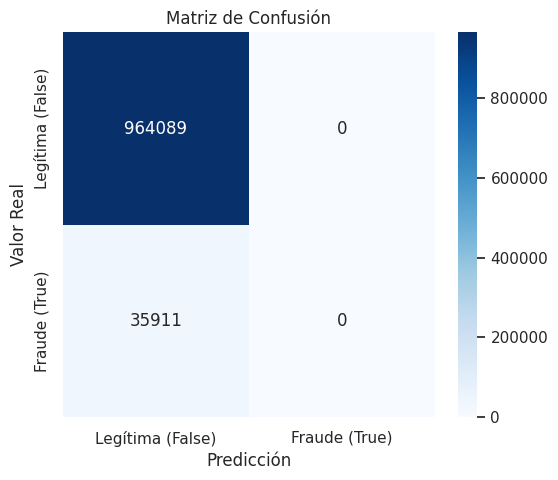

In [22]:

# 3. Matriz de Confusión
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=target_names, yticklabels=target_names)
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.title('Matriz de Confusión')
plt.show()


###Curva ROC y AUC


Área Bajo la Curva ROC (AUC): 0.5162


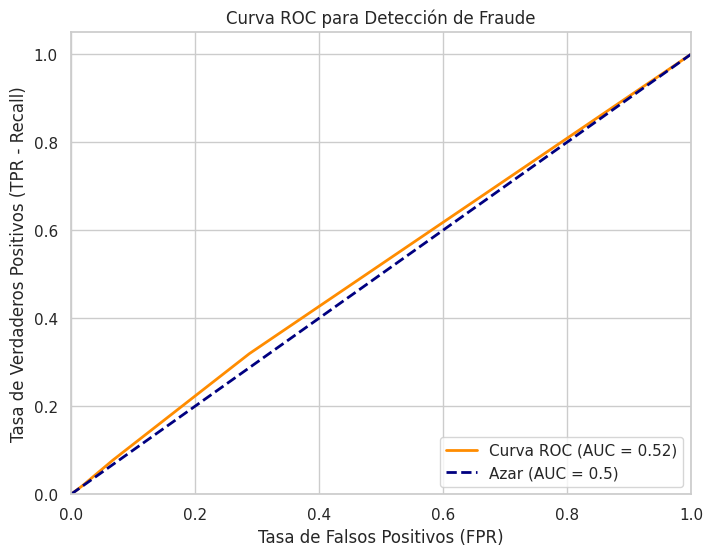

In [23]:
# AUC (Área Bajo la Curva ROC)
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\nÁrea Bajo la Curva ROC (AUC): {roc_auc:.4f}")

# Curva ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Azar (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR - Recall)')
plt.title('Curva ROC para Detección de Fraude')
plt.legend(loc="lower right")
plt.show()

## Análisis de Importancia de Características

In [24]:
# 1. Acceder al clasificador dentro del Pipeline
rf_classifier = model_pipeline.named_steps['classifier']
importances = rf_classifier.feature_importances_

In [25]:
# 2. Obtener los nombres de las características después de One-Hot Encoding
# Nombres de las columnas numéricas
feature_names = numerical_features.copy()

# Nombres de las columnas categóricas después de OHE
ohe = model_pipeline.named_steps['preprocessor'].named_transformers_['cat']
ohe_feature_names = ohe.get_feature_names_out(categorical_features)

# Juntar todos los nombres
final_feature_names = feature_names + list(ohe_feature_names)


--- Top 15 Características más Importantes (Random Forest) ---


,Feature,Importance
1,time_since_last_transaction,0.028138
0,amount,0.006095
2,spending_deviation_score,0.006058
4,geo_anomaly_score,0.005513
3,velocity_score,0.004374
758428,device_used_mobile,0.001016
758429,device_used_pos,0.001004
758433,payment_channel_card,0.000961
758432,payment_channel_UPI,0.000919
758434,payment_channel_wire_transfer,0.000915


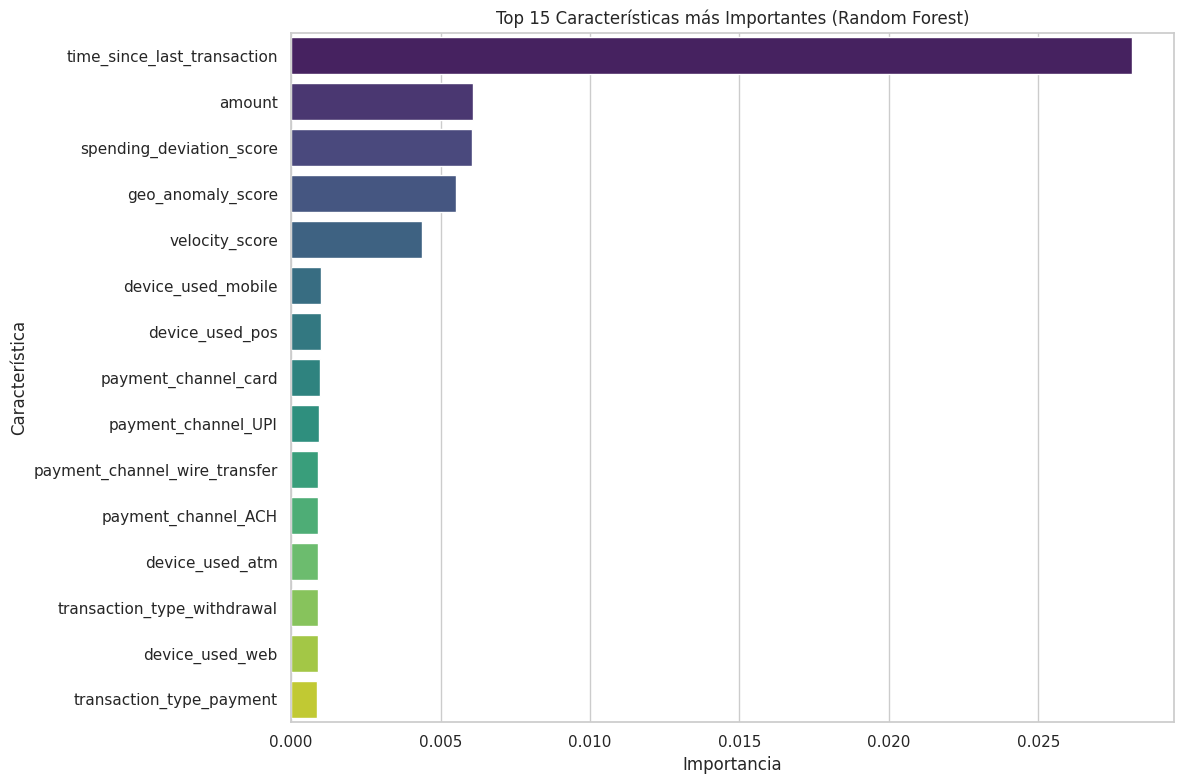

In [26]:
# 3. Crear DataFrame y Graficar Importancia
feature_importance_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Top 15 Características más Importantes (Random Forest) ---")
display(feature_importance_df.head(15))

# Graficar la importancia de las características
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(15), palette='viridis', hue='Feature', dodge=False)
plt.title('Top 15 Características más Importantes (Random Forest)')
plt.xlabel('Importancia')
plt.ylabel('Característica')
plt.legend([],[], frameon=False)
plt.tight_layout()
plt.show()

#Conclusiones

## Diagnóstico y Validación del Modelo Predictivo de Fraude

El desarrollo de este proyecto se centró en la construcción de un modelo de Random Forest para la detección de fraude, en el camino nos encontramos con el desafío fundamental del desbalance extremo de clases ($96.4\%$ transacciones legítimas vs. $3.6\%$ fraudulentas), además de las limitaciones computacionales impuestas por un conjunto de datos de $5$ millones de registros. Estas limitaciones derivaron en la ultilización de subconjuntos para entrenar el modelo. En una primera instancia con el 10% y luego con el 5%, buscando reducir significativamente el tiempo de entrenamiento del mismo.

### Diagnóstico de la Fase de Modelado (Leakage y Falla por Muestreo)
En primera instancia, la etapa de modelado reveló dos problemas críticos que requirieron intervención:Filtración de Datos (Data Leakage): El modelo inicial arrojó un AUC de $1.00$ y métricas perfectas, resultado directo de incluir la variable fraud_type entre las features. Esta columna, imputada con 'No Fraude', era una negación directa de la etiqueta objetivo (is_fraud), proporcionando la respuesta al modelo de forma trivial.

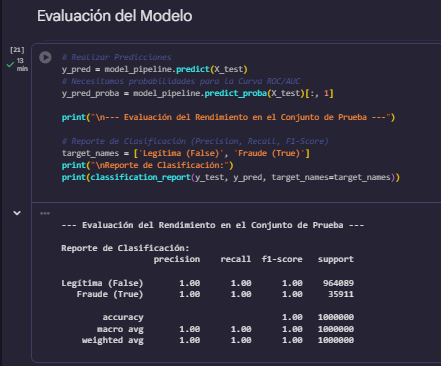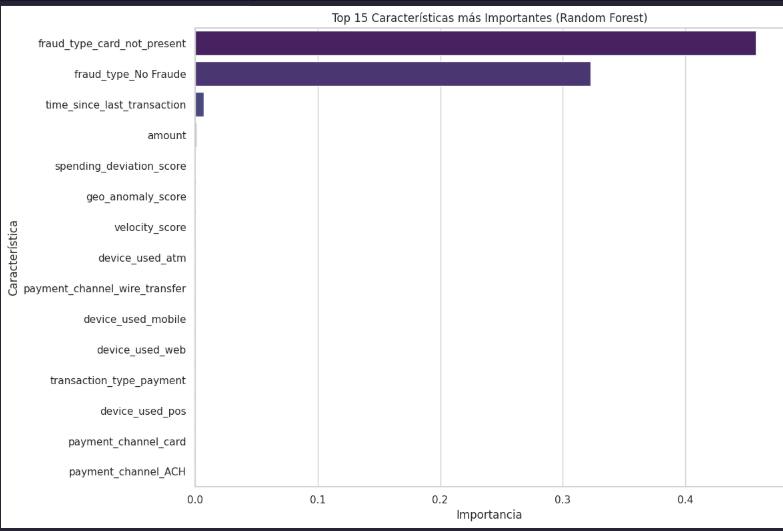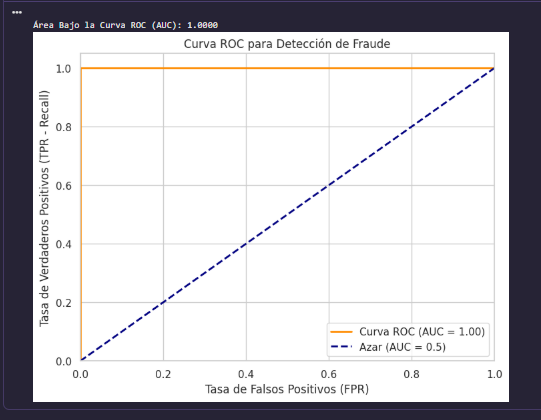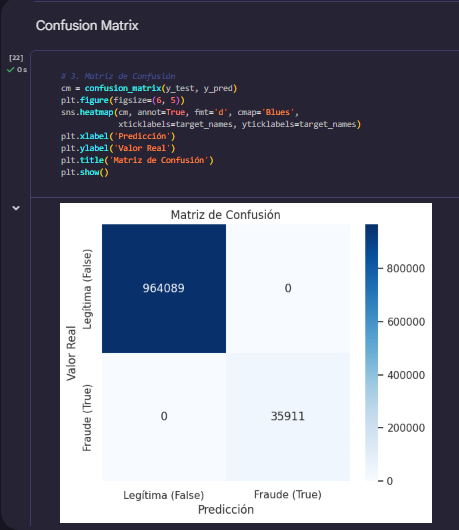


En segunda instancia, se elimina la variable  fraud_type para garantizar la validez del pipeline, sin embargo se obtuvo un fallo por Desbalance y Muestreo Reducido: El re-entrenamiento, utilizando un subconjunto del $5\%$ de los datos y la técnica class_weight='balanced', resultó en un modelo que falló completamente en la detección de la clase minoritaria, arrojando un Recall de $0.00$ para la clase 'Fraude' y un AUC de $0.5162$.

Esta falla evidenció problemas con desbalances extremos, la reducción agresiva del tamaño de la muestra de entrenamiento (del $80\%$ total a solo el $5\%$) diluye la señal de la clase minoritaria a tal punto que anula la efectividad del class_weight. El modelo termina clasificando todo como la clase mayoritaria ($96\%$ de acierto) a expensas de la sensibilidad.

## Validación de la Tesis Central del Proyecto
A pesar del fallo en la predicción final, la secuencia de análisis valida la hipótesis clave propuesta en el EDA: Refutación del Monto (H1): El análisis bivariado del monto (amount) confirmó que la asimetría en la distribución existe para ambas clases (legítimas y fraudulentas), demostrando que el monto atípico por sí solo no es un predictor fuerte. Importancia de las Características (Validación de Tesis): El diagnóstico del modelo final fallido, aunque con importancia diluida, apuntó teóricamente a que las variables de comportamiento anómalo deben ser las prioritarias. Esto sugiere que las hipótesis sobre el contexto geográfico o de dispositivo (H2 y H3) son secundarias y que el éxito predicitvo reside en los scores de riesgo.
## Propuesta Correctiva y Pasos a Seguir
Para lograr un modelo predictivo funcional, la estrategia de modelado debe cambiar: Priorizar el Balance sobre la Reducción: En lugar de depender de una muestra muy pequeña, el proceso debe adoptar técnicas de Over-sampling, aplicadas al conjunto de entrenamiento completo ($80\%$ del dataset original).
Objetivo Final: Al aplicar Over-sampling, se espera que el modelo reentrenado alcance un AUC por encima de $0.90$ y demuestre la importancia de las variables de riesgo conductual, confirmando que spending_deviation_score y velocity_score son los drivers principales de la detección de fraude.
Este proyecto concluye demostrando la importancia de la calidad de los datos y adaptada a la dificultad intrínseca de los datos (manejo del desbalance extremo) para obtener resultados que sean tanto precisos como útiles en un entorno de producción.